# Labelfree 2D
As the downstream tasks for the image compression. From the brightfield image to the fluorescent image.

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# import modules:
import os, sys
sys.path.append("../../")
from pathlib import Path
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import random
from compressai.zoo import image_models
from utils import compression_ratio_space_savings, plot_data, write_metrics

os.environ['CUDA_VISIBLE_DEVICES'] = "3"
!export CUDA_VISIBLE_DEVICES=3 
_SEED = 0
np.random.seed(_SEED)
random.seed(_SEED)
os.environ["PYTHONHASHSEED"] = str(_SEED)

In [49]:
# set parameters

# which cell line to download: in the paper, we tested on four nuclear structures:
# - fibrillarin (cline = "FBL")
# - nucleophosmin (cline = "NPM1")
# - lamin b1 (cline = "LMNB1")
# - histon H2B (cline = "HIST1H2BJ")
cline = "FBL"

# set up path 3D
parent_path_3d = Path("../../../../data/labelfree3D") / f"{cline}"
train_path_3d = parent_path_3d / Path("train")
holdout_path_3d = parent_path_3d / Path("holdout")

# set up path 2D
parent_path_2d = Path("../../../../data/labelfree2D") / f"{cline}"
train_path_2d = parent_path_2d / Path("train")
holdout_path_2d = parent_path_2d / Path("holdout")

## Model Training

Requires to install mmv_im2im [package](https://github.com/MMV-Lab/mmv_im2im). Use JPEGXR compressed images as training data.

In [ ]:
# Firstly we train a basic fnet as the generator of the pix2pix network
!run_im2im --config ./train_generator.yaml


In [ ]:
# then train the whole network.
!run_im2im --config ./train.yaml

## Inference

In [ ]:
prediction= 'prediction' 

for dir in [i for i in holdout_path_2d.glob('*') if i.is_dir() and any(j.is_file() for j in i.glob('*'))]:
    Path(dir/prediction).mkdir(exist_ok=True)
    !echo {dir.name}
    !run_im2im --config ./inference.yaml --model.checkpoint ./lightning_logs/version_1/checkpoints/best.ckpt --data.inference_input.dir {dir} --data.inference_output.path {dir/prediction}

## Evaluation

In [ ]:
# compare with gt:
write_metrics(holdout_path_2d, Path("./") / "labelfree_2d_metric_gt.csv", pred=True)
# compare with original prediction:
write_metrics(
    holdout_path_2d,
    Path("./") / "labelfree_2d_metric_original.csv",
    pred=True,
    compare_with_original=True,
)

## Illustration

We randomly pick up one image and one compresstion technique to illustrate the result. You can also specify these values.

In [56]:
compression_technique = random.choices(
    [i.name for i in holdout_path_2d.iterdir() if i.is_dir() and i.name != "original"]
)
img_path = random.choice([i for i in holdout_path_2d.glob("*_IM.tiff")])

We choose 8958_IM.tiff as the illustration.
cheng2020-attn_ms-ssim_6_RGB


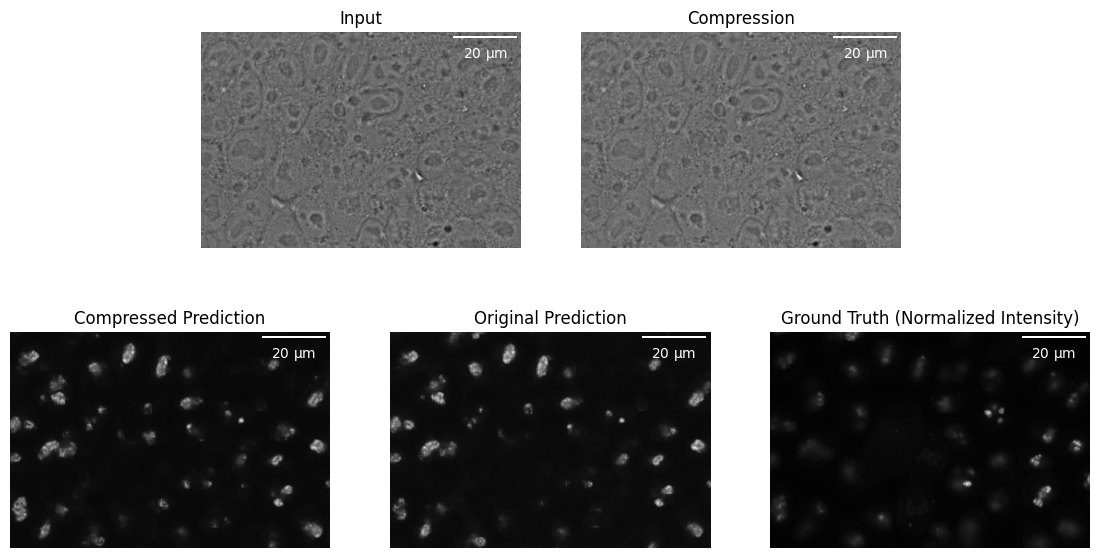

In [57]:
plot_data(img_path, compression_technique)